# **动量策略多空组合构建**

### **1. 内容简介**  
使用Python复现Daniel和Moskowitz的Momentum策略。  

动量投资是一种购买过去三到十二个月回报率高的股票或其他证券，并卖出同期回报率低的股票或其他证券的策略。

- 动量投资策略的主要论据是反应不足和保守心理，研究认为动量交易策略能够获利，存在着许多解释：  
    - 一种解释是：“收益动量”，即当股票收益的增长超过预期，或者当投资者一致预测股票未来收益的增长时，股票的收益会趋于升高。
        - 因此，动量交易策略所获得的利润是由于股票基本价值的变动带来的。  
    - 另一种解释是：基于价格动量和收益动量的策略因为利用了市场对不同信息的反应不足而获利。

目前关于动量策略的解释还没有共识，因为它难以与有效市场假说和随机游走假说相协调，但是动量投资作为一种投资策略的有效性已经得到公认。

1. 数据来源为CRSP，使用在NYSE、AME、NASDAQ(hexcd=1,2,3)上市的所有公司股票数据；  
2. 同时只利用普通股的回报 (shrcd=10,11)，并要求公司股价和股票数量必须是有效的。  
3. 使用以上数据构建每月动量十分位的投资组合（即按照每月Momentum进行排序，将股票分成10个档次,最低的10%股票设置为低组1，最高的10%股票为高组10)，投资组合在月底进行再平衡。  


**Momentum的构建方式如下**：
- 假如现在为T时刻，把T-12到T-2时刻共计11个月份的复合收益率作为T时刻的Momentum，此时跳过了T-1时刻，是为了避免价格逆转的情况；
- 也可以理解为观察Momentum和构建投资组合均需要时间，然后在T时刻持有该投资组合一个月并计算收益率。
- 在计算Momentum的11个月中至少有8个月的是有效回报数据。

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

In [6]:
crsp = pd.read_csv('E:/Replications/02/csv_export/crsp_monthly.csv', dtype={'gvkey': str})

In [7]:
crsp.head()

,permno,date,month,ret,shrout,altprc,exchcd,siccd,mktcap,mktcap_lag,exchange,industry,ret_excess,gvkey
0,10028,1993-03-31,1993-03-01,-0.100000,5626000.0,1.1250,2,5094,6.329250,7.032500,AMEX,Wholesale,-0.102500,012096
1,10028,1993-04-30,1993-04-01,0.388889,5626000.0,1.5625,2,5094,8.790625,6.329250,AMEX,Wholesale,0.386489,012096
2,10028,1993-05-28,1993-05-01,0.200000,5626000.0,1.8750,2,5094,10.548750,8.790625,AMEX,Wholesale,0.197800,012096
3,10028,1993-06-30,1993-06-01,-0.133333,5566000.0,-1.6250,2,5094,9.044750,10.548750,AMEX,Wholesale,-0.135833,012096
4,10028,1993-07-30,1993-07-01,0.192308,5566000.0,1.9375,2,5094,10.784125,9.044750,AMEX,Wholesale,0.189908,012096


### **2. 数据预处理**
定义以下两个函数，第一个函数是将日期数据调整到当月的最后一天。  
第二个函数将传入的序列按照十分位进行切割，该函数是为了获取Momentum前10%的股票和后10%的股票，注意该函数把null值排除在外，以便于我们构建投资组合。

In [9]:
def end_of_month(x):
    if not isinstance(x, str):
        return x
    return str(pd.to_datetime(x) + pd.tseries.offsets.MonthEnd(0))[:10]

In [10]:
def apply_quantiles(x, include_in_quantiles=None, bins = 10):
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0,1,bins+1)
    )
    quantiles[0] = x.min() - 1
    quantiles[-1] = x.max() + 1
    
    return pd.cut(x, quantiles, labels=False) + 1

**筛选普通股和NYSE、AME、NASDAQ交易所上市的公司股票。并且去除每只股票在开始日期和结束日期之间的空缺数据，保留每只股票在这段时间内的所有数据记录**。

In [12]:
msf = crsp.copy()
#msf = msf[msf['shrcd'].isin(set([10,11]))]
msf = msf[msf['exchcd'].isin(set([1,2,3]))]

msf = msf.sort_values(['permno','date'])
unique_dates = msf.assign(dummy=1)[['date','dummy']].drop_duplicates()

In [13]:
start_end_every_stock = (msf.groupby('permno', group_keys = False)
                         .agg(start=('date','min'), end=('date','max'))
                         .assign(dummy = 1)
                         .reset_index()[['permno','start','end','dummy']])

start_end_every_stock

,permno,start,end,dummy
0,10000,1986-02-28,1987-05-29,1
1,10001,1986-02-28,2017-07-31,1
2,10002,1986-02-28,2013-01-31,1
3,10003,1986-02-28,1995-11-30,1
4,10005,1986-02-28,1991-06-28,1
...,...,...,...,...
25969,93432,2010-07-30,2011-05-31,1
25970,93433,2010-07-30,2016-11-30,1
25971,93434,2010-07-30,2022-12-30,1
25972,93435,2010-07-30,2012-04-30,1


In [14]:
msf_no_gaps = (pd.merge(start_end_every_stock, unique_dates, how='outer', on='dummy')
               .query('date >= start & date <= end'))

msf = pd.merge(msf, msf_no_gaps[['permno','date']], how='right', on=['permno','date'])
msf.head()

,permno,date,month,ret,shrout,altprc,exchcd,siccd,mktcap,mktcap_lag,exchange,industry,ret_excess,gvkey
0,10000,1986-02-28,1986-02-01,-0.257143,3680000.0,-3.250000,3.0,3990.0,11.960000,16.100000,NASDAQ,Manufacturing,-0.262443,013007
1,10000,1986-03-31,1986-03-01,0.365385,3680000.0,-4.437500,3.0,3990.0,16.330000,11.960000,NASDAQ,Manufacturing,0.359385,013007
2,10000,1986-04-30,1986-04-01,-0.098592,3793000.0,-4.000000,3.0,3990.0,15.172000,16.330000,NASDAQ,Manufacturing,-0.103792,013007
3,10000,1986-05-30,1986-05-01,-0.222656,3793000.0,-3.109375,3.0,3990.0,11.793859,15.172000,NASDAQ,Manufacturing,-0.227556,013007
4,10000,1986-06-30,1986-06-01,-0.005025,3793000.0,-3.093750,3.0,3990.0,11.734594,11.793859,NASDAQ,Manufacturing,-0.010225,013007


In [15]:
#msf = pd.merge(msf,( msf[['date']].drop_duplicates()
#                    .assign(end_of_month=lambda df: df['date'].apply(end_of_month))), on = 'date')

msf = msf[['permno','date','altprc','exchcd','ret','mktcap_lag']]
msf = msf.sort_values(['permno','date']).reset_index(drop=True)
msf

,permno,date,altprc,shrout,exchcd,ret,end_of_month,mktcap_lag
0,10000,1986-02-28,-3.250000,3.680000e+06,3.0,-0.257143,1986-02-28,16.100000
1,10000,1986-03-31,-4.437500,3.680000e+06,3.0,0.365385,1986-03-31,11.960000
2,10000,1986-04-30,-4.000000,3.793000e+06,3.0,-0.098592,1986-04-30,16.330000
3,10000,1986-05-30,-3.109375,3.793000e+06,3.0,-0.222656,1986-05-31,15.172000
4,10000,1986-06-30,-3.093750,3.793000e+06,3.0,-0.005025,1986-06-30,11.793859
...,...,...,...,...,...,...,...,...
3401853,93436,2022-08-31,275.609985,3.133470e+09,3.0,-0.072489,2022-08-31,931110.623250
3401854,93436,2022-09-30,265.250000,3.158000e+09,3.0,-0.037589,2022-09-30,863615.620800
3401855,93436,2022-10-31,227.539993,3.157752e+09,3.0,-0.142168,2022-10-31,837659.500000
3401856,93436,2022-11-30,194.699997,3.157752e+09,3.0,-0.144326,2022-11-30,718514.868879


### **3. 计算动量因子**
该部分的计算步骤如之前所述，把T-12到T-2时刻共计11个月份的复合收益率作为T时刻的动量因子，并且这11个月的有效收益数据必须大于等于8个。

In [17]:
#msf['mktcap']=np.abs(msf['altprc'] * msf['shrout'])
#msf['mktcap_lag1'] = msf.groupby(['permno'])['mktcap'].shift(1)

def rolling_prod(a, n=11):
    ret = np.cumprod(a.values)
    ret[n:] = ret[n:] / ret[:-n]
    ret[:n-1] = np.nan
    return pd.Series(ret, index = a.index)

In [39]:
msf['rollret_11'] = (msf.assign(ret=(msf['ret'].fillna(0)+1))
                     .groupby('permno', group_keys = False)['ret']
                     .apply(rolling_prod))-1
msf['rollret_11']

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: rollret_11, dtype: float64

In [41]:
msf['rollvalidobs'] = (msf.assign(ret = msf['ret'].notnull())
                       .groupby('permno', group_keys = False)['ret']
                       .rolling(11)
                       .sum()).reset_index([0],drop=True)

msf['rollvalidobs']

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: rollvalidobs, dtype: float64

In [43]:
msf['index'] = msf.groupby('permno', group_keys = False).apply(lambda group:pd.Series(range(1, len(group)+1))).reset_index(drop=True)
msf.loc[(msf['index']<=10) | (msf['rollvalidobs']<8), 'rollret_11']=np.nan
msf

,permno,date,altprc,shrout,exchcd,ret,end_of_month,mktcap_lag,rollret_11,rollvalidobs,index
0,10000,1986-02-28,-3.250000,3.680000e+06,3.0,-0.257143,1986-02-28,16.100000,NaN,NaN,1
1,10000,1986-03-31,-4.437500,3.680000e+06,3.0,0.365385,1986-03-31,11.960000,NaN,NaN,2
2,10000,1986-04-30,-4.000000,3.793000e+06,3.0,-0.098592,1986-04-30,16.330000,NaN,NaN,3
3,10000,1986-05-30,-3.109375,3.793000e+06,3.0,-0.222656,1986-05-31,15.172000,NaN,NaN,4
4,10000,1986-06-30,-3.093750,3.793000e+06,3.0,-0.005025,1986-06-30,11.793859,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...
3401853,93436,2022-08-31,275.609985,3.133470e+09,3.0,-0.072489,2022-08-31,931110.623250,0.066217,11.0,146
3401854,93436,2022-09-30,265.250000,3.158000e+09,3.0,-0.037589,2022-09-30,863615.620800,-0.285682,11.0,147
3401855,93436,2022-10-31,227.539993,3.157752e+09,3.0,-0.142168,2022-10-31,837659.500000,-0.403700,11.0,148
3401856,93436,2022-11-30,194.699997,3.157752e+09,3.0,-0.144326,2022-11-30,718514.868879,-0.447283,11.0,149


In [45]:
msf['momentum'] = msf.groupby('permno')['rollret_11'].shift(2)

In [56]:
msf['altprc_lag1'] = msf.groupby(['permno'], group_keys = False)['altprc'].shift(1)
msf['altprc_lag13'] = msf.groupby(['permno'], group_keys = False)['altprc'].shift(13)

### **4. 按照动量因子对股票进行分类**
- 接下来我们对每个月的股票进行十分位的划分，由低到高，设置Momentum最低10% 的bin number为1，依次上升，Momentum最好的10%股票的bin nummber为10；
- equal weighted的投资组合每只股票的的权重为1，value weighted的投资组合权重为股票的市值，计算两种投资组合的return。

In [58]:
msf2 = msf[(msf['momentum'].notnull() &
            msf['ret'].notnull() &
            msf['mktcap_lag'].notnull() &
            (np.abs(msf['altprc_lag1'])>=1) &
            (msf['rollvalidobs'] >= 8) &
            msf['altprc_lag13'].notnull())].copy().reset_index(drop=True)
msf2

,permno,date,altprc,shrout,exchcd,ret,end_of_month,mktcap_lag,rollret_11,rollvalidobs,index,momentum,altprc_lag1,altprc_lag13
0,10001,1987-03-31,6.375000,9.910000e+05,3.0,0.036800,1987-03-31,6.193750,0.066689,11.0,14,0.150413,6.250000,-6.250000
1,10001,1987-04-30,-6.125000,9.910000e+05,3.0,-0.039216,1987-04-30,6.317625,0.035005,11.0,15,0.039014,6.375000,-6.312500
2,10001,1987-05-29,-5.687500,9.910000e+05,3.0,-0.071429,1987-05-31,6.069875,-0.026197,11.0,16,0.066689,-6.125000,-6.375000
3,10001,1987-06-30,5.875000,9.910000e+05,3.0,0.051429,1987-06-30,5.636312,0.034440,11.0,17,0.035005,-5.687500,-6.312500
4,10001,1987-07-31,6.000000,9.910000e+05,3.0,0.021277,1987-07-31,5.822125,-0.014658,11.0,18,-0.026197,5.875000,-6.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826700,93436,2022-08-31,275.609985,3.133470e+09,3.0,-0.072489,2022-08-31,931110.623250,0.066217,11.0,146,-0.020052,891.450012,687.200012
2826701,93436,2022-09-30,265.250000,3.158000e+09,3.0,-0.037589,2022-09-30,863615.620800,-0.285682,11.0,147,0.211670,275.609985,735.719971
2826702,93436,2022-10-31,227.539993,3.157752e+09,3.0,-0.142168,2022-10-31,837659.500000,-0.403700,11.0,148,0.066217,265.250000,775.479980
2826703,93436,2022-11-30,194.699997,3.157752e+09,3.0,-0.144326,2022-11-30,718514.868879,-0.447283,11.0,149,-0.285682,227.539993,1114.000000


In [60]:
msf2['bp'] = (msf2.groupby('date')
               .apply(lambda group: apply_quantiles(group['momentum'], 
                                                    bins=10, 
                                                    include_in_quantiles=(group['exchcd']==1)))
              ).reset_index(level=[0], drop=True).sort_index()

msf2.head()

,permno,date,altprc,shrout,exchcd,ret,end_of_month,mktcap_lag,rollret_11,rollvalidobs,index,momentum,altprc_lag1,altprc_lag13,bp
0,10001,1987-03-31,6.3750,991000.0,3.0,0.036800,1987-03-31,6.193750,0.066689,11.0,14,0.150413,6.2500,-6.2500,6
1,10001,1987-04-30,-6.1250,991000.0,3.0,-0.039216,1987-04-30,6.317625,0.035005,11.0,15,0.039014,6.3750,-6.3125,4
2,10001,1987-05-29,-5.6875,991000.0,3.0,-0.071429,1987-05-31,6.069875,-0.026197,11.0,16,0.066689,-6.1250,-6.3750,4
3,10001,1987-06-30,5.8750,991000.0,3.0,0.051429,1987-06-30,5.636312,0.034440,11.0,17,0.035005,-5.6875,-6.3125,5
4,10001,1987-07-31,6.0000,991000.0,3.0,0.021277,1987-07-31,5.822125,-0.014658,11.0,18,-0.026197,5.8750,-6.1250,4


In [62]:
portfolios = (msf2.groupby(['date','bp'], group_keys = False)
              .apply(lambda g: pd.Series({
                  'portfolio_ew': g['ret'].mean(),
                  'portfolio_vw': (g['ret'] * g['mktcap_lag']).sum() / g['mktcap_lag'].sum()}))).reset_index()

portfolios.sort_values(['date','bp']).head()

,date,bp,portfolio_ew,portfolio_vw
0,1961-03-30,1,0.056714,0.043996
1,1961-03-30,2,0.033559,0.013825
2,1961-03-30,3,0.039234,0.010039
3,1961-03-30,4,0.039570,0.016454
4,1961-03-30,5,0.051397,0.018537


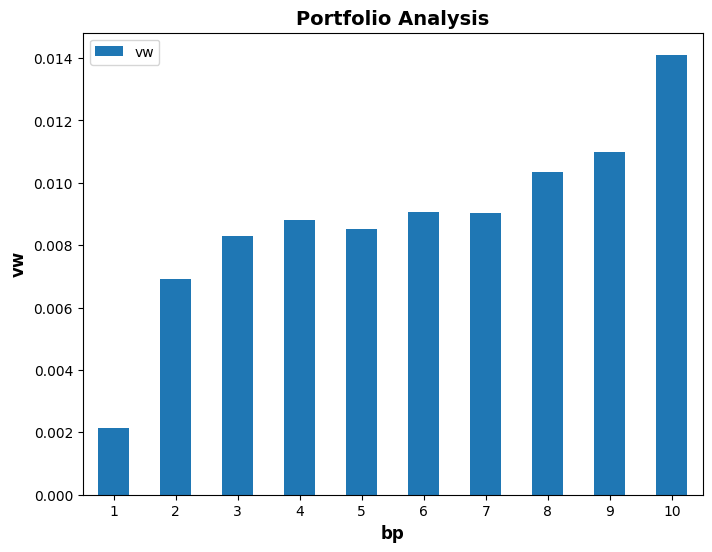

In [88]:
# 绘制柱状图
dta = portfolios.groupby('bp', group_keys=False).agg(vw=('portfolio_vw', 'mean')).sort_values('bp')
plt.rcParams['figure.figsize'] = (8, 6)
ax = dta.plot(kind='bar')
# 设置横纵坐标轴字体大小、加粗，以及坐标轴名称
plt.xlabel('bp', fontsize=12, fontweight='bold')  
plt.ylabel('vw', fontsize=12, fontweight='bold') 
plt.title('Portfolio Analysis', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.show()

### **5. 构建投资组合**
我们采用买多Momentum前10% 的股票，卖空后10% 的股票构建投资组合，根据不同的市场只进行买多Momentum前10%的股票依然可以，但同时因为风险敞口放大，波动率也将会有所提升。因为我们的数据是基于美股市场，因此可以选择卖空Momentum后10%的股票。

In [66]:
portfolios2 = pd.merge(portfolios.query('bp==10'),
                       portfolios.query('bp==1'),
                       suffixes = ['_long','_short'], 
                       on = 'date')
portfolios2

,date,bp_long,portfolio_ew_long,portfolio_vw_long,bp_short,portfolio_ew_short,portfolio_vw_short
0,1961-03-30,10,0.080860,0.045494,1,0.056714,0.043996
1,1961-04-28,10,0.017938,0.003624,1,-0.021706,-0.063174
2,1961-05-31,10,0.019334,0.015040,1,0.063600,0.074226
3,1961-06-30,10,-0.051199,-0.022849,1,-0.056042,-0.044505
4,1961-07-31,10,0.016426,0.018402,1,-0.009091,0.014760
...,...,...,...,...,...,...,...
737,2022-08-31,10,0.021618,-0.005056,1,0.011783,-0.031190
738,2022-09-30,10,-0.106292,-0.071019,1,-0.148190,-0.117307
739,2022-10-31,10,0.132983,0.164890,1,0.019928,0.067782
740,2022-11-30,10,-0.001904,0.019882,1,-0.044442,0.010027


In [68]:
portfolios2['strategy_vw'] = portfolios2['portfolio_vw_long'] - portfolios2['portfolio_vw_short']
portfolios2 = portfolios2.sort_values('date')
portfolios2.head()

,date,bp_long,portfolio_ew_long,portfolio_vw_long,bp_short,portfolio_ew_short,portfolio_vw_short,strategy_vw
0,1961-03-30,10,0.080860,0.045494,1,0.056714,0.043996,0.001498
1,1961-04-28,10,0.017938,0.003624,1,-0.021706,-0.063174,0.066798
2,1961-05-31,10,0.019334,0.015040,1,0.063600,0.074226,-0.059187
3,1961-06-30,10,-0.051199,-0.022849,1,-0.056042,-0.044505,0.021655
4,1961-07-31,10,0.016426,0.018402,1,-0.009091,0.014760,0.003642


### **6. 绘制P&L曲线**

In [70]:
portfolios2['strategy_ew'] = portfolios2['portfolio_ew_long']-portfolios2['portfolio_ew_short']
portfolios2['cum_ew'] = (portfolios2['strategy_ew'] + 1).cumprod() - 1
portfolios2['cum_vw'] = (portfolios2['strategy_vw'] + 1).cumprod() - 1
portfolios2

,date,bp_long,portfolio_ew_long,portfolio_vw_long,bp_short,portfolio_ew_short,portfolio_vw_short,strategy_vw,strategy_ew,cum_ew,cum_vw
0,1961-03-30,10,0.080860,0.045494,1,0.056714,0.043996,0.001498,0.024147,0.024147,0.001498
1,1961-04-28,10,0.017938,0.003624,1,-0.021706,-0.063174,0.066798,0.039644,0.064748,0.068396
2,1961-05-31,10,0.019334,0.015040,1,0.063600,0.074226,-0.059187,-0.044266,0.017616,0.005161
3,1961-06-30,10,-0.051199,-0.022849,1,-0.056042,-0.044505,0.021655,0.004843,0.022544,0.026928
4,1961-07-31,10,0.016426,0.018402,1,-0.009091,0.014760,0.003642,0.025517,0.048636,0.030669
...,...,...,...,...,...,...,...,...,...,...,...
737,2022-08-31,10,0.021618,-0.005056,1,0.011783,-0.031190,0.026134,0.009836,3057.024302,908.053695
738,2022-09-30,10,-0.106292,-0.071019,1,-0.148190,-0.117307,0.046288,0.041898,3185.148931,950.132127
739,2022-10-31,10,0.132983,0.164890,1,0.019928,0.067782,0.097108,0.113056,3545.361691,1042.494650
740,2022-11-30,10,-0.001904,0.019882,1,-0.044442,0.010027,0.009855,0.042538,3696.216393,1052.778025


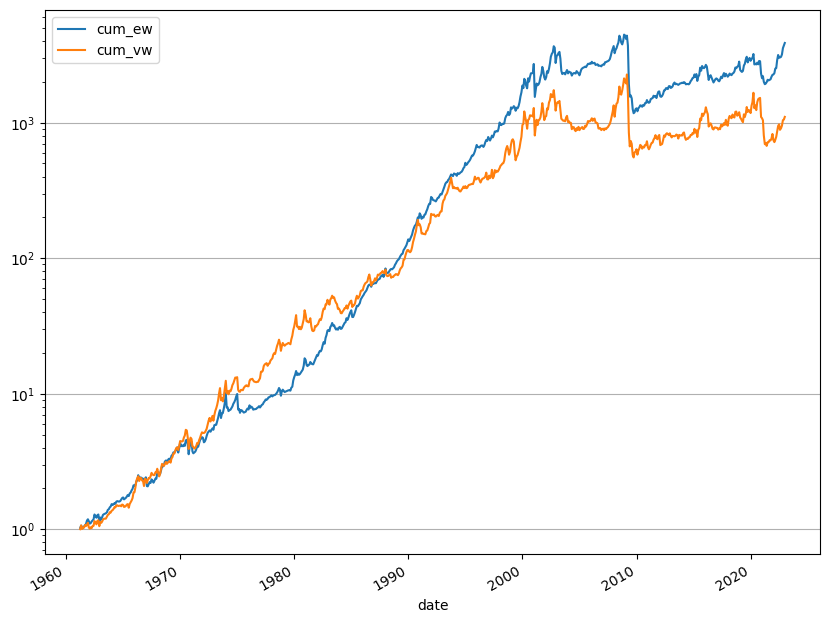

In [72]:
(portfolios2
 .assign(date=pd.to_datetime(portfolios2['date']))
 .assign(cum_vw=portfolios2['cum_vw']+1)
 .assign(cum_ew=portfolios2['cum_ew']+1)
 .plot(x='date',y=['cum_ew','cum_vw'], logy=True).grid(axis='y'))

#### **发现**
- 价值加权的投资组合表现要优于等权重的投资组合，说明价格较低的股票波动率更大，趋势特征很难维持，因为其很容易受到市场的扰动，
- 尤其是使用equal weighted构建投资策略的时候，低价股票占比更高，其波动性对于动量趋势的干扰越强，使得整体的表现不如value weighted构建的投资组合。
- 这种情况下，低股价小公司的高波动性占了主导因素。

#### **接下来使用同样的方式，但过滤条件设置为prc>5，以此来减少低价股票的影响**：

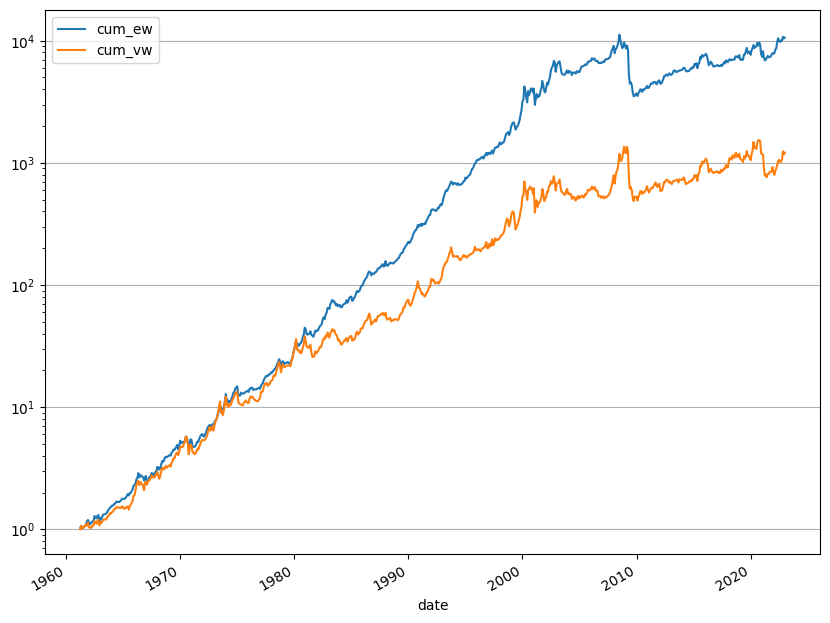

In [80]:
def performAnalysis(msf3):
    msf3['bp'] = (msf3
                   .groupby('date')
                   .apply(lambda group: apply_quantiles(group['momentum'], bins = 10, include_in_quantiles = (group['exchcd']==1)))
                  ).reset_index(level=[0], drop=True).sort_index()
    
    portfolios = (msf3
                  .groupby(['date','bp'])
                  .apply(lambda g: pd.Series({
                      'portfolio_ew': g['ret'].mean(),
                      'portfolio_vw': (g['ret']*g['mktcap_lag']).sum() / g['mktcap_lag'].sum()}))).reset_index()
    
    portfolios2 = pd.merge(portfolios.query('bp==10'),
                           portfolios.query('bp==1'),
                           suffixes = ['_long','_short'], on='date')
    
    portfolios2['strategy_vw'] = portfolios2['portfolio_vw_long'] - portfolios2['portfolio_vw_short']
    portfolios2 = portfolios2.sort_values('date')
    portfolios2['cum_vw'] = (portfolios2['strategy_vw']+1).cumprod()-1
    portfolios2['strategy_ew'] = portfolios2['portfolio_ew_long']-portfolios2['portfolio_ew_short']
    portfolios2['cum_ew'] = (portfolios2['strategy_ew']+1).cumprod()-1
    
    (portfolios2
     .assign(date=pd.to_datetime(portfolios2['date']))
     .assign(cum_vw=portfolios2['cum_vw']+1)
     .assign(cum_ew=portfolios2['cum_ew']+1)
     .plot(x='date', y=['cum_ew','cum_vw'],logy=True).grid(axis='y'))

performAnalysis(msf2.query('altprc_lag1>=5'))    

#### **发现**
当我们把价格区间设置为prc>5时，equal weighted投资组合表现要好于value weighted投资组合，因为此时我们市值高的股票，市场的参与者越多，信息传递的速度较快，因此动量维持的时间较短，而此时低市值的股票收到关注度较低，因此有动量持续的时间相较于高市值的股票持续的时间将会更长一些，因此更容易被该策略识别到，收益表现也会更加优秀。

### **7. 结果分析**
- 从结果来看在正常环境中，持续的价格势头在收益表现上很强劲，但是在经济危机之后（1929年2008年经济危机之后），糟糕的市场状况改善并且市场开始反弹时，过去表现不好的股票会出现强劲的反弹，因此会导致动量策略的崩溃，因为动量策略会做空这些股票，这也是为什么在这样的时间段动量策略出现了较大的回撤。
- 总的来说，动量策略的有效性是得到验证的，并且目前对于动量策略的研究仍是热点，大多数是基于动量策略进行不同方式的加权来获得新的动量因子排序。

---
---
---

### **8. 补充研究**
- 在之前构建的投资组合中，我们假设动量趋势是能够延续的，接下来用数据验证这种趋势的延续性，并观察持续时间。

In [92]:
msf2 = msf[(msf['altprc_lag1'].abs()>=1)
            & msf['momentum'].notnull() 
            & msf['ret'].notnull() 
            & msf['mktcap_lag'].notnull()]

In [94]:
for i in range(1,26):
    msf2[f'lead{i}'] = msf2.groupby('permno')['ret'].shift(-i)

def weighted_mean_mine(x,y):
    delete = x.isnull() | y.isnull()
    x = x[~delete]
    y = y[~delete]
    
    return (x * y).sum() / y.sum()

msf2['bp']=(msf2.groupby('date').apply(lambda group: apply_quantiles(group['momentum'],bins=10))).reset_index(level=[0], drop=True).sort_index()



In [96]:
msf3=(msf2.groupby(['date','bp'])
      .apply(lambda g: pd.Series([
          weighted_mean_mine(g["ret"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead1"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead2"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead3"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead4"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead5"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead6"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead7"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead8"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead9"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead10"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead11"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead12"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead13"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead14"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead15"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead16"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead17"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead18"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead19"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead20"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead21"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead22"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead23"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead24"],g["mktcap_lag"]),
          weighted_mean_mine(g["lead25"],g["mktcap_lag"])]))
     )

msf3.columns = ['lead{}'.format(i) for i in range(26)]
msf3 = msf3.reset_index()

#### **我们得到每个月不同分位数股票的lead0到lead25的return数据，此时的return数据是根据市值加权计算得到，lead0表示当月的收益，lead1表示未来一个月的收益。**

In [98]:
msf4 = pd.melt(msf3, id_vars=['date','bp'])
msf4 = msf4.dropna()

msf4['horizon'] = msf4['variable'].str[4:].apply(int)
msf4.head()

,date,bp,variable,value,horizon
0,1961-02-28,1,lead0,0.077628,0
1,1961-02-28,2,lead0,0.041074,0
2,1961-02-28,3,lead0,0.046649,0
3,1961-02-28,4,lead0,0.004111,0
4,1961-02-28,5,lead0,0.053308,0


In [102]:
msf5 = (msf4.groupby(['bp','horizon']).agg(ret=('value','mean')).reset_index())

start = (msf5.pivot(index='horizon', columns='bp', values='ret').assign(spread=lambda df: df.loc[:,10]-df.loc[:,1]))

plt.rcParams["figure.figsize"]=(14,10)
start['cumspread'] = (start['spread']+1).cumprod()-1
start

bp,1,2,3,4,5,6,7,8,9,10,spread,cumspread
horizon,,,,,,,,,,,,
0,-0.000946,0.003395,0.006344,0.007862,0.008358,0.008557,0.009738,0.010739,0.011429,0.015579,0.016525,0.016525
1,0.000469,0.004244,0.007572,0.007660,0.008674,0.009248,0.010161,0.010724,0.011565,0.014616,0.014147,0.030906
2,0.002105,0.005212,0.007938,0.008136,0.008704,0.009021,0.009448,0.009933,0.012145,0.013003,0.010898,0.042141
3,0.002460,0.006027,0.007612,0.008284,0.008553,0.008543,0.009848,0.009751,0.011356,0.013497,0.011037,0.053643
4,0.003688,0.006130,0.007663,0.008148,0.008810,0.008890,0.009111,0.010326,0.011199,0.012837,0.009148,0.063282
5,0.005302,0.006777,0.008109,0.008715,0.008214,0.009591,0.009848,0.009578,0.011652,0.011505,0.006203,0.069877
6,0.005630,0.007265,0.008557,0.009124,0.008386,0.009663,0.009794,0.009478,0.010974,0.011298,0.005668,0.075942
7,0.007102,0.007171,0.009314,0.009202,0.008781,0.010011,0.009991,0.008853,0.011449,0.009686,0.002585,0.078722
8,0.008267,0.008604,0.009489,0.008494,0.009115,0.010457,0.009235,0.009319,0.010358,0.009061,0.000794,0.079579


#### **简单调整之后得到平均十个分位数，lead0到lead25的return，spread为做多bp为10 的股票，做空bp为1的股票，表示投资组合的收益情况。**

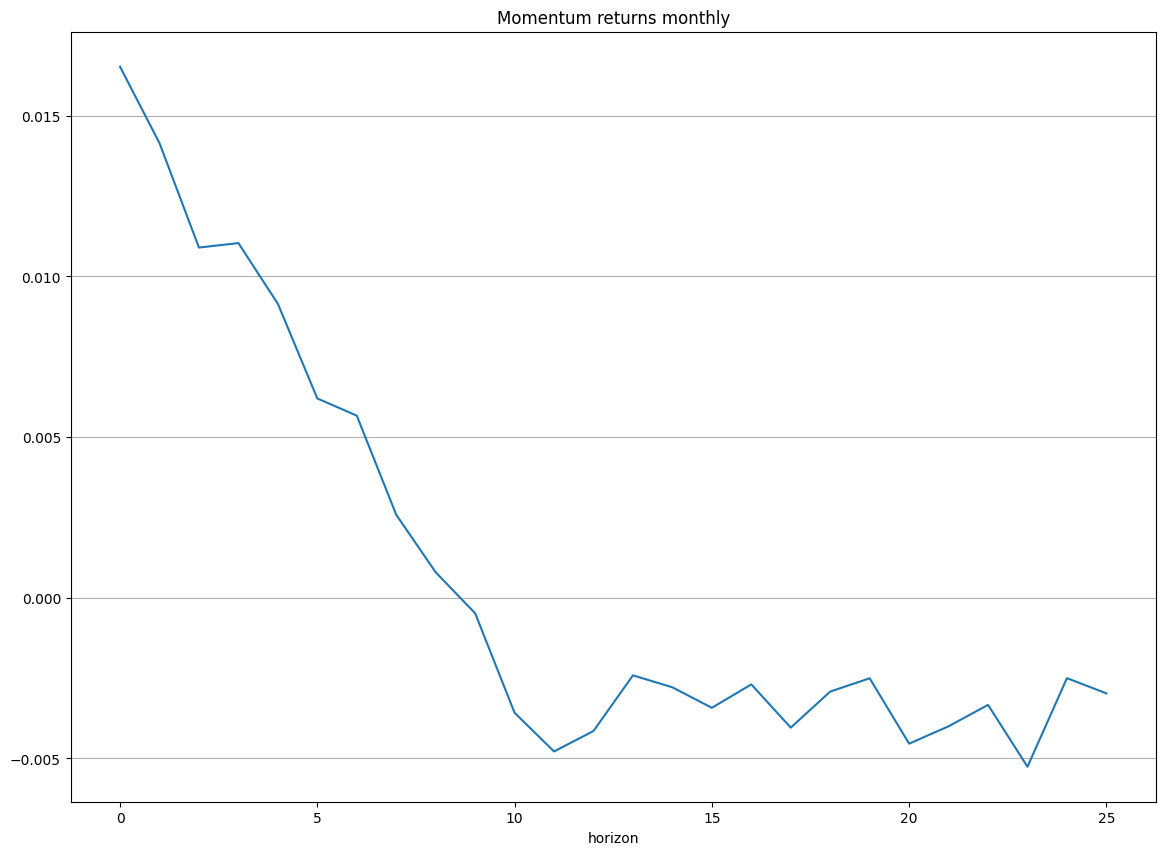

In [104]:
start['spread'].plot(title='Momentum returns monthly').grid(axis='y')

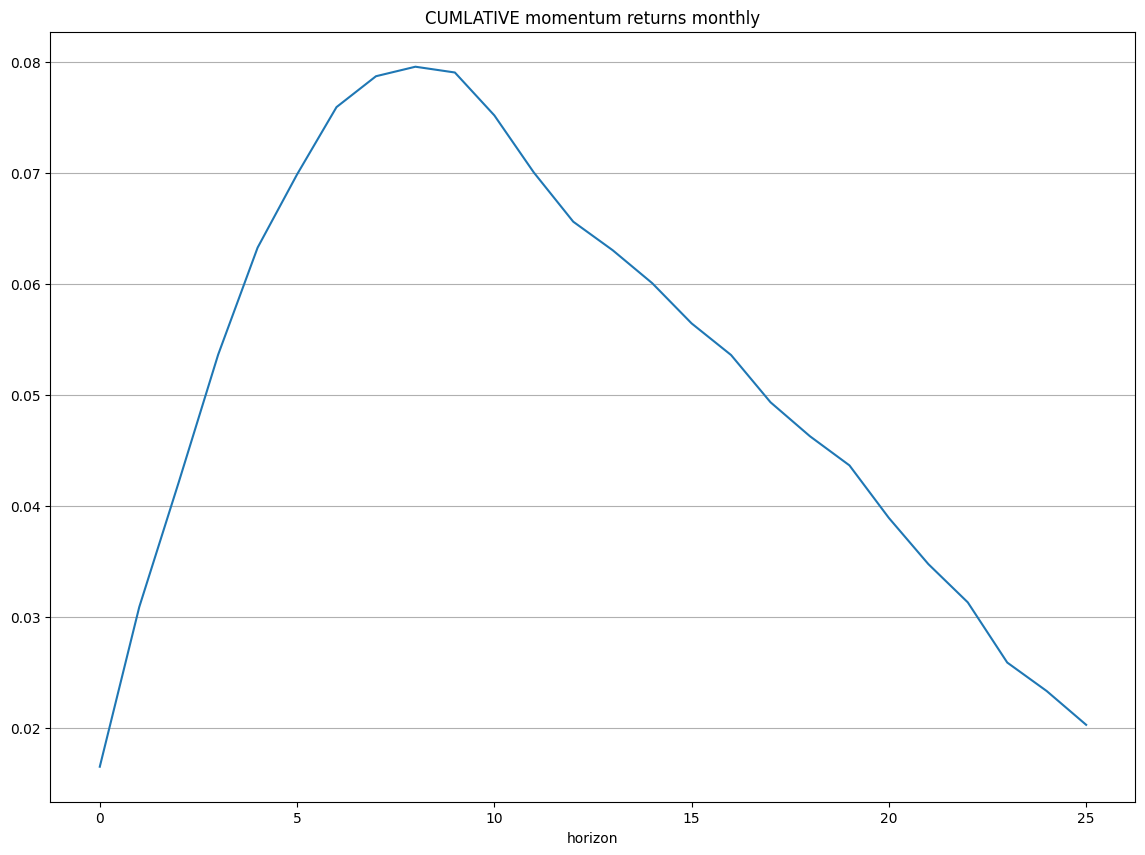

In [106]:
start['cumspread'].plot(title='CUMLATIVE momentum returns monthly').grid(axis='y')

#### **根据图像，lead7为正，lead8为负，即大约在在六个月后，趋势收益降为0，那么这种趋势延续性是能够被我们的投资组合捕捉到的。以上是对于Momentum延续性的简单验证。**

### **9. 总结**
- 综合来看，Momentum策略拥有短期内获得高利润的潜力，它能够跟随市场的趋势，并且利用了市场其他投资者的情绪，这一点是基于行为金融学的分析。
- 然而Momentum策略依然有其缺点，比如该投资组合的周转周期短，周转率较高，这将会加大交易成本；
- 并且动量策略在牛市中有较大的优势，因为此时投资者倾向于羊群效应，放大了这种趋势，但是在熊市中，投资者更为谨慎，这种趋势性策略就不那么有效，同时还会有动量崩溃的风险。